<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://goo.gl/rvvZiR).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

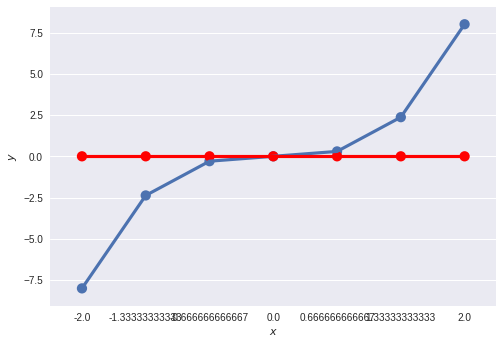

In [49]:
X = np.linspace(-2, 2, 7)
y = X ** 3

# plt.scatter(X, y)
sns.pointplot(X, y)
plt.xlabel(r'$x$');
plt.ylabel(r'$y$');

sns.pointplot(X, np.zeros(7), color='red');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график.

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

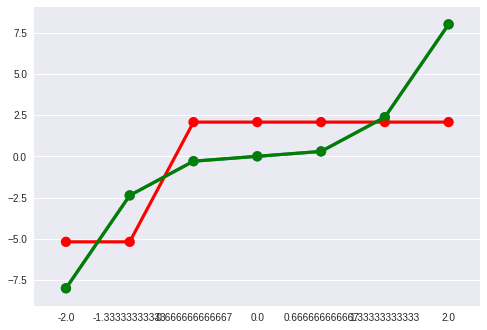

In [232]:
l = [sum(X[X < 0]) / len(X[X < 0]) for _ in range(len(X[X < 0]))]
r = [sum(X[X >=0 ]) / len(X[X >= 0]) for _ in range(len(X[X >= 0]))]

l = list(y)[:2]
l = [sum(l) / len(l) for _ in range(len(l))]
r = list(y)[2:]
r = [sum(r) / len(r) for _ in range(len(r))]

sns.pointplot(X, y)
sns.pointplot(X, l+r, color='red');

from sklearn.tree import DecisionTreeRegressor

reg = DecisionTreeRegressor()
Xr = np.reshape(X, (7, 1))
pred = reg.fit(Xr, y)
pr = pred.predict(Xr)

sns.pointplot(X, pr, color='green')

export_graphviz(reg,
out_file='../../img/optimal_tree.dot', 
                filled=False)

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [266]:
def dispersion(X, y):
    return (1 / len(X) * 
            sum([(yj - 1/len(X) * sum([yi for yi in y])**2 )
                 for yj in y])
           )

def regression_var_criterion(X, y, t):
    return (dispersion(X, X ** 3) - 
            len(X[X<=t])/len(X) * 
            dispersion(X[X<=t], X[X<=t] ** 3) - 
            len(X[X>t])/len(X) * 
            dispersion(X[X>t], X[X>t] ** 3)
           )

T = np.linspace(-1.9, 1.9, 30)
rc = [regression_var_criterion(X, y, t) for t in T]

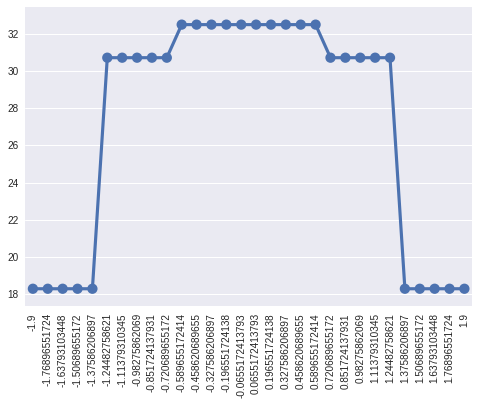

In [284]:
import matplotlib.ticker as ticker

ax = sns.pointplot(T, rc)
ax.set_xticklabels(T, rotation=90)
plt.show()

In [269]:
T

array([-1.9       , -1.76896552, -1.63793103, -1.50689655, -1.37586207,
       -1.24482759, -1.1137931 , -0.98275862, -0.85172414, -0.72068966,
       -0.58965517, -0.45862069, -0.32758621, -0.19655172, -0.06551724,
        0.06551724,  0.19655172,  0.32758621,  0.45862069,  0.58965517,
        0.72068966,  0.85172414,  0.98275862,  1.1137931 ,  1.24482759,
        1.37586207,  1.50689655,  1.63793103,  1.76896552,  1.9       ])

In [103]:
X

array([-2.        , -1.33333333, -0.66666667,  0.        ,  0.66666667,
        1.33333333,  2.        ])

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

array([-8.        , -2.37037037,  0.59259259,  0.59259259,  0.59259259,
        0.59259259,  8.        ])

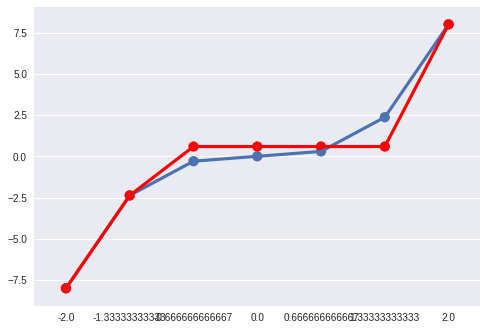

In [211]:
reg = DecisionTreeRegressor(max_depth=2)
Xr = np.reshape(X, (7, 1))
pred = reg.fit(Xr, y)
pr = pred.predict(Xr)

sns.pointplot(X, y)
sns.pointplot(X, pr, color='red')

pr

**<font color='red'>Вопрос 2.</font> Из скольки отрезков состоит график, изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 7

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [108]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [111]:
len(df)

70000

Сделайте небольшие преобразования признаков: постройте признак "возраст в годах", а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`.

Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [112]:
from sklearn.model_selection import train_test_split

In [136]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop(['cardio'], axis=1), df.cardio, test_size=0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [222]:

X_train = pd.get_dummies(X_train, columns=['cholesterol'])



ValueError: labels ['cholesterol'] not contained in axis

In [228]:

tree = DecisionTreeRegressor(max_depth=3, random_state=17)
pred = tree.fit(X_train, y_train)
pr = pred.predict(X_train)

In [230]:
X_train.columns

Index(['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'gluc', 'smoke',
       'alco', 'active', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3'],
      dtype='object')

ap_hi
age
cholesterol =3

In [229]:
from sklearn.tree import export_graphviz
export_graphviz(tree,
out_file='../../img/small_tree.dot', 
                filled=False)


**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- age, ap_hi, chol=3

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [141]:
from sklearn.model_selection import GridSearchCV

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [155]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(tree,
                         tree_params,
                         cv=5
                        )

tree_grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=17,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [153]:

tree_grid.cv_results_

{'mean_fit_time': array([ 0.06230373,  0.05827284,  0.06719661,  0.07908654,  0.10290904,
         0.09618349,  0.10180449,  0.12728972,  0.12035356]),
 'mean_score_time': array([ 0.00149245,  0.00153027,  0.00146999,  0.00163951,  0.00212426,
         0.00167222,  0.0017715 ,  0.00195417,  0.00189128]),
 'mean_test_score': array([ 0.2365529 ,  0.25641966,  0.26454863,  0.26810432,  0.27069299,
         0.26620709,  0.25894004,  0.24709612,  0.23150488]),
 'mean_train_score': array([ 0.23663433,  0.25666584,  0.26678026,  0.27431515,  0.28256709,
         0.29127426,  0.3021243 ,  0.3161388 ,  0.33440745]),
 'param_max_depth': masked_array(data = [2 3 4 5 6 7 8 9 10],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'params': ({'max_depth': 2},
  {'max_depth': 3},
  {'max_depth': 4},
  {'max_depth': 5},
  {'max_depth': 6},
  {'max_depth': 7},
  {'max_depth': 8},
  {'max_depth': 9},
  {'max_depth': 10}),
 'rank_test_score': array([8

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

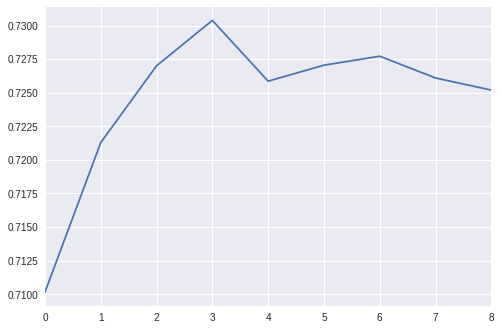

In [178]:
from sklearn.metrics import accuracy_score

scores = []
for d in range(2, 11):
    tree = DecisionTreeRegressor(max_depth=d, random_state=17)
    y_pred = tree.fit(X_train, y_train)
    y_pred = tree.predict(X_valid)
    score = accuracy_score(np.array(y_valid), y_pred.round(), normalize=True)
    scores.append(score)
    
sns.tsplot(scores)

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева четкий пик, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке?**
- да, да

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках.

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**

- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)

In [205]:
df_bin = pd.get_dummies(df, columns=['cholesterol'])
gender_map = {1:0, 2: 1}
df_bin['male'] = df_bin.gender.map(gender_map)
df_bin['age_years'] = (df_bin['age'] / 365.25).round().astype('int')
years_1 = df_bin[df_bin.age_years >= 45][df_bin.age_years < 50]
df_bin['years_45_50'] = [1 if age >= 45 and age < 50 else 0 for age in df_bin.age_years]
df_bin['years_50_55'] = [1 if age >= 50 and age < 55 else 0 for age in df_bin.age_years]
df_bin['years_55_60'] = [1 if age >= 55 and age < 60 else 0 for age in df_bin.age_years] 
df_bin['years_60_65'] = [1 if age >= 60 and age < 65 else 0 for age in df_bin.age_years]

df_bin['ap_hi_120_140'] = [1 if ap_hi >= 120 and ap_hi < 140 else 0 for ap_hi in df_bin.ap_hi]
df_bin['ap_hi_140_160'] = [1 if ap_hi >= 140 and ap_hi < 160 else 0 for ap_hi in df_bin.ap_hi]
df_bin['ap_hi_160_180'] = [1 if ap_hi >= 160 and ap_hi < 180 else 0 for ap_hi in df_bin.ap_hi]

df_bin = df_bin[['cardio', 
                'smoke',
                'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 
                'male', 
                'years_45_50', 'years_50_55', 'years_55_60', 'years_60_65',
                'ap_hi_120_140', 'ap_hi_140_160', 'ap_hi_160_180']]

/home/suh/.venv/tf/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """


,cardio,smoke,cholesterol_1,cholesterol_2,cholesterol_3,male,years_45_50,years_50_55,years_55_60,years_60_65,ap_hi_120_140,ap_hi_140_160,ap_hi_160_180
id,,,,,,,,,,,,,
0,0,0,1,0,0,1,0,1,0,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,0,1,0
2,1,0,0,0,1,0,0,1,0,0,1,0,0
3,1,0,1,0,0,1,1,0,0,0,0,1,0
4,0,0,1,0,0,0,1,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,1,1,0,0
9,0,0,0,0,1,0,0,0,0,1,1,0,0
12,1,0,0,0,1,1,0,0,0,1,1,0,0
13,0,0,1,0,0,0,1,0,0,0,0,0,0


In [210]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)

train = df_bin.drop('cardio', axis=1)

tree.fit(train, df_bin.cardio)


export_graphviz(tree,
out_file='../../img/final_tree.dot', 
                filled=False)

list(enumerate(train.columns))


[(0, 'smoke'),
 (1, 'cholesterol_1'),
 (2, 'cholesterol_2'),
 (3, 'cholesterol_3'),
 (4, 'male'),
 (5, 'years_45_50'),
 (6, 'years_50_55'),
 (7, 'years_55_60'),
 (8, 'years_60_65'),
 (9, 'ap_hi_120_140'),
 (10, 'ap_hi_140_160'),
 (11, 'ap_hi_160_180')]